In [19]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.model_selection import train_test_split

In [2]:
# preprocessing pt 1

df_orders = pd.read_csv('dataset/olist_orders_dataset.csv', parse_dates=['order_purchase_timestamp'])
df_customers = pd.read_csv('dataset/olist_customers_dataset.csv')
df_order_items = pd.read_csv('dataset/olist_order_items_dataset.csv')
df_reviews = pd.read_csv('dataset/olist_order_reviews_dataset.csv')
df_products =  pd.read_csv('dataset/olist_products_dataset.csv')
df_trans = pd.read_csv('dataset/product_category_name_translation.csv')
df_items = pd.read_csv('dataset/olist_order_items_dataset.csv')

df = df_orders.merge(df_customers, on='customer_id', how='left')

In [3]:
# First-order data preprocessing (pt 2)

# 1. Get first order per customer
df_fo = (
    df.sort_values(['customer_unique_id', 'order_purchase_timestamp'])
      .groupby('customer_unique_id')
      .first()
      .reset_index()
)

# 2. Add order count and repeat flag
order_counts = df.groupby('customer_unique_id')['order_id'].nunique().reset_index()
order_counts['repeat_order'] = (order_counts['order_id'] > 1).astype(int)
df_fo = df_fo.merge(order_counts[['customer_unique_id', 'repeat_order']], on='customer_unique_id', how='left')

# 3. Merge review scores (mean per order)
reviews_agg = df_reviews.groupby('order_id')['review_score'].mean().reset_index()
df_fo = df_fo.merge(reviews_agg, on='order_id', how='left')

# 4. Merge product categories for first orders
df_items_first_orders = df_order_items[df_order_items['order_id'].isin(df_fo['order_id'])].copy()
df_items_first_orders = (
    df_items_first_orders
    .merge(df_products[['product_id', 'product_category_name']], on='product_id', how='left')
    .merge(df_trans[['product_category_name', 'product_category_name_english']], on='product_category_name', how='left')
)

# Aggregate product categories per order
product_agg = (
    df_items_first_orders.groupby('order_id')['product_category_name_english']
    .agg(lambda x: ', '.join(sorted(set(x.dropna()))))
    .reset_index()
)
df_fo = df_fo.merge(product_agg, on='order_id', how='left')

# 5. Seller stats for first orders
df_first_order_items = df_order_items[df_order_items['order_id'].isin(df_fo['order_id'])]
seller_agg = (
    df_first_order_items.groupby('order_id')
    .agg(n_sellers=('seller_id', 'nunique'), first_seller=('seller_id', 'first'))
    .reset_index()
)
df_fo = df_fo.merge(seller_agg, on='order_id', how='left')

# 6. Derived time features
df_fo['order_delivered_customer_date'] = pd.to_datetime(df_fo['order_delivered_customer_date'], errors='coerce')
df_fo['order_estimated_delivery_date'] = pd.to_datetime(df_fo['order_estimated_delivery_date'], errors='coerce')
df_fo['order_purchase_timestamp'] = pd.to_datetime(df_fo['order_purchase_timestamp'], errors='coerce')
df_fo['order_approved_at'] = pd.to_datetime(df_fo['order_approved_at'], errors='coerce')

df_fo['delay'] = (df_fo['order_delivered_customer_date'] - df_fo['order_estimated_delivery_date']).dt.days
df_fo['approval_time_hours'] = (
    (df_fo['order_approved_at'] - df_fo['order_purchase_timestamp']).dt.total_seconds() / 3600
)
df_fo['delivery_time_days'] = (
    (df_fo['order_delivered_customer_date'] - df_fo['order_purchase_timestamp']).dt.days
)

# 7. Drop unused columns
df_fo = df_fo.drop([
    'order_delivered_customer_date', 'order_estimated_delivery_date',
    'order_delivered_carrier_date', 'order_approved_at',
    'order_purchase_timestamp', 'order_status',
    'customer_state', 'customer_zip_code_prefix'
], axis=1)

# 8. Keep valid deliveries only
df_fo = df_fo[~df_fo['delivery_time_days'].isna()].copy()

# 9. Drop duplicates
df_fo = df_fo.drop_duplicates()
df_fo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 93356 entries, 0 to 96095
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   customer_unique_id             93356 non-null  object 
 1   order_id                       93356 non-null  object 
 2   customer_id                    93356 non-null  object 
 3   customer_city                  93356 non-null  object 
 4   repeat_order                   93356 non-null  int64  
 5   review_score                   92732 non-null  float64
 6   product_category_name_english  93326 non-null  object 
 7   n_sellers                      93326 non-null  float64
 8   first_seller                   93326 non-null  object 
 9   delay                          93356 non-null  float64
 10  approval_time_hours            93343 non-null  float64
 11  delivery_time_days             93356 non-null  float64
dtypes: float64(5), int64(1), object(6)
memory usage: 9.

In [22]:
# Repeat order model + feature importance

# 1. Aggregate product categories for the first order
df_items_first_orders_tmp = df_order_items[df_order_items['order_id'].isin(df_fo['order_id'])].copy()
df_items_first_orders_tmp = (
    df_items_first_orders_tmp
    .merge(df_products[['product_id', 'product_category_name']], on='product_id', how='left')
    .merge(df_trans[['product_category_name', 'product_category_name_english']], on='product_category_name', how='left')
)

product_agg = (
    df_items_first_orders_tmp
    .groupby('order_id')['product_category_name_english']
    .agg(lambda x: '_'.join(sorted(set(x.dropna()))))
    .reset_index()
    .rename(columns={'product_category_name_english': 'product_categories_first_order'})
)

# Create new copy of df_fo (don’t overwrite it)
df_fo_extended = df_fo.merge(product_agg, on='order_id', how='left')

# 2. Feature set
features = [
    'review_score', 'delay', 'approval_time_hours', 'delivery_time_days',
    'customer_city', 'product_categories_first_order', 'first_seller'
]
X = df_fo_extended[features].copy()
y = df_fo_extended['repeat_order'].copy()

cat_features = ['customer_city', 'product_categories_first_order', 'first_seller']
for col in cat_features:
    X[col] = X[col].fillna('missing').astype(str)

# 3. Train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 4. Train model
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    depth=3,
    learning_rate=0.05,
    iterations=500,
    eval_metric='AUC',
    class_weights=[1, 2],
    random_seed=42,
    cat_features=cat_features,
    verbose=0
)
model.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True)

# 5. Evaluation
from sklearn.metrics import classification_report
pred = model.predict(X_test)
print(classification_report(y_test, pred))
y_pred_proba = model.predict_proba(X_test)[:, 1]

# 6. Feature importance
import pandas as pd
feat_imp = (
    pd.DataFrame({'feature': X_train.columns, 'importance': repeat_model.feature_importances_})
    .sort_values(by='importance', ascending=False)
)
print(feat_imp.head(20))


              precision    recall  f1-score   support

           0       0.97      1.00      0.98     18076
           1       0.87      0.02      0.04       596

    accuracy                           0.97     18672
   macro avg       0.92      0.51      0.51     18672
weighted avg       0.97      0.97      0.95     18672

                          feature  importance
5  product_categories_first_order   27.115235
6                    first_seller   21.524761
1                           delay   15.282744
2             approval_time_hours   13.351536
3              delivery_time_days   10.672217
0                    review_score    6.814131
4                   customer_city    5.239376


In [8]:
# some metrics
print(f"average approval time: {df_fo['approval_time_hours'].mean().round(0)} hours")
print(f"average delay: {df_fo['delay'].mean().round(0)} days")
print(f"average delievery time: {df_fo['delivery_time_days'].mean().round(0)} days")

average approval time: 10.0 hours
average delay: -12.0 days
average delievery time: 12.0 days


In [23]:
# Simulation lab

NUMERIC_COLS = ['review_score', 'delay', 'approval_time_hours', 'delivery_time_days']
CAT_COLS = ['customer_city', 'product_categories_first_order', 'first_seller']


def simulate_by_resample(
    base_df,
    n_samples=10000,
    random_seed=42,
    review_score_value=None, review_score_mul=None,
    delay_value=None, delay_mul=None,
    approval_time_value=None, approval_time_mul=None,
    delivery_time_value=None, delivery_time_mul=None,
    city_probs=None, category_probs=None, seller_probs=None,
    clamp_review=(1, 5),
    min_nonnegatives={'approval_time_hours': 0.01, 'delivery_time_days': 0.0}
):
    """Generate synthetic data via bootstrap with simple feature modifications."""
    np.random.seed(random_seed)
    idx = np.random.choice(base_df.index.values, size=n_samples, replace=True)
    X = base_df.loc[idx].reset_index(drop=True).copy()

    def apply_shift(col, value, mul):
        if value is not None:
            X[col] += (value - X[col].mean())
        elif mul is not None:
            X[col] *= mul

    apply_shift('review_score', review_score_value, review_score_mul)
    apply_shift('delay', delay_value, delay_mul)
    apply_shift('approval_time_hours', approval_time_value, approval_time_mul)
    apply_shift('delivery_time_days', delivery_time_value, delivery_time_mul)

    if clamp_review is not None:
        X['review_score'] = X['review_score'].clip(clamp_review[0], clamp_review[1])

    for col, min_val in min_nonnegatives.items():
        if col in X.columns:
            X[col] = X[col].clip(lower=min_val)

    def sample_cat(col, probs):
        if probs is None or col not in X.columns:
            return
        if isinstance(probs, dict):
            vals, p = list(probs.keys()), np.array(list(probs.values()), float)
            p /= p.sum()
            X[col] = np.random.choice(vals, size=len(X), p=p)
        else:
            vals = list(probs)
            X[col] = np.random.choice(vals, size=len(X))

    sample_cat('customer_city', city_probs)
    sample_cat('product_categories_first_order', category_probs)
    sample_cat('first_seller', seller_probs)

    for c in CAT_COLS:
        if c in X.columns:
            X[c] = X[c].fillna('missing').astype(str)

    return X


def evaluate_scenario(X_gen, model, threshold=0.5, cat_features=None):
    """Evaluate scenario using model predictions."""
    try:
        probs = model.predict_proba(X_gen)[:, 1]
    except Exception:
        from catboost import Pool
        pool = Pool(X_gen, cat_features=cat_features or [])
        probs = model.predict_proba(pool)[:, 1]

    mean_prob = probs.mean()
    pred_rate = (probs >= threshold).mean()
    return {'mean_prob': mean_prob, 'pred_rate': pred_rate, 'probs': probs}


def compare_scenarios(base_df, model, baseline_params, improved_params,
                      n_samples=10000, threshold=0.5, cat_features=None):
    """Compare baseline and improved simulation scenarios."""
    X_base = simulate_by_resample(base_df, n_samples=n_samples, **baseline_params)
    res_base = evaluate_scenario(X_base, model, threshold, cat_features)

    X_imp = simulate_by_resample(base_df, n_samples=n_samples, **improved_params)
    res_imp = evaluate_scenario(X_imp, model, threshold, cat_features)

    abs_change = res_imp['mean_prob'] - res_base['mean_prob']
    rel_change = (abs_change / res_base['mean_prob']) * 100 if res_base['mean_prob'] > 0 else 0

    print(f"Base mean_prob={res_base['mean_prob']:.4f}, pred_rate={res_base['pred_rate']:.2%}")
    print(f"Improved mean_prob={res_imp['mean_prob']:.4f}, pred_rate={res_imp['pred_rate']:.2%}")
    print(f"Change abs={abs_change:+.4f}, rel={rel_change:+.1f}%\n")

    return {
        'X_base': X_base,
        'X_improved': X_imp,
        'baseline': res_base,
        'improved': res_imp,
        'abs_change': abs_change,
        'rel_change': rel_change
    }


# --------------------------------------------------------------------------
# Tests
# --------------------------------------------------------------------------

print("Main test: moderate improvements (approval_time -50%, delivery_time -10%)\n")
results_1 = compare_scenarios(
    base_df=X_train,
    model=model,
    baseline_params={'random_seed': 42},
    improved_params={'approval_time_mul': 0.5, 'delivery_time_mul': 0.90, 'random_seed': 42},
    n_samples=10000,
    cat_features=CAT_COLS
)

print("Check test: strong improvements (approval_time -80%, delivery_time -20%, review_score → 4.5)\n")
results_2 = compare_scenarios(
    base_df=X_train,
    model=model,
    baseline_params={'random_seed': 42},
    improved_params={'approval_time_mul': 0.2, 'delivery_time_mul': 0.8, 'review_score_value': 4.5, 'random_seed': 42},
    n_samples=10000,
    cat_features=CAT_COLS
)

print("Check test: service degradation (approval_time +50%, delay = 5 days)\n")
results_3 = compare_scenarios(
    base_df=X_train,
    model=model,
    baseline_params={'random_seed': 42},
    improved_params={'approval_time_mul': 1.5, 'delay_value': 5, 'random_seed': 42},
    n_samples=10000,
    cat_features=CAT_COLS
)

Main test: moderate improvements (approval_time -50%, delivery_time -10%)

Base mean_prob=0.0599, pred_rate=0.08%
Improved mean_prob=0.0653, pred_rate=0.08%
Change abs=+0.0054, rel=+9.0%

Check test: strong improvements (approval_time -80%, delivery_time -20%, review_score → 4.5)

Base mean_prob=0.0599, pred_rate=0.08%
Improved mean_prob=0.1906, pred_rate=8.15%
Change abs=+0.1307, rel=+218.0%

Check test: service degradation (approval_time +50%, delay = 5 days)

Base mean_prob=0.0599, pred_rate=0.08%
Improved mean_prob=0.0509, pred_rate=0.07%
Change abs=-0.0090, rel=-15.1%



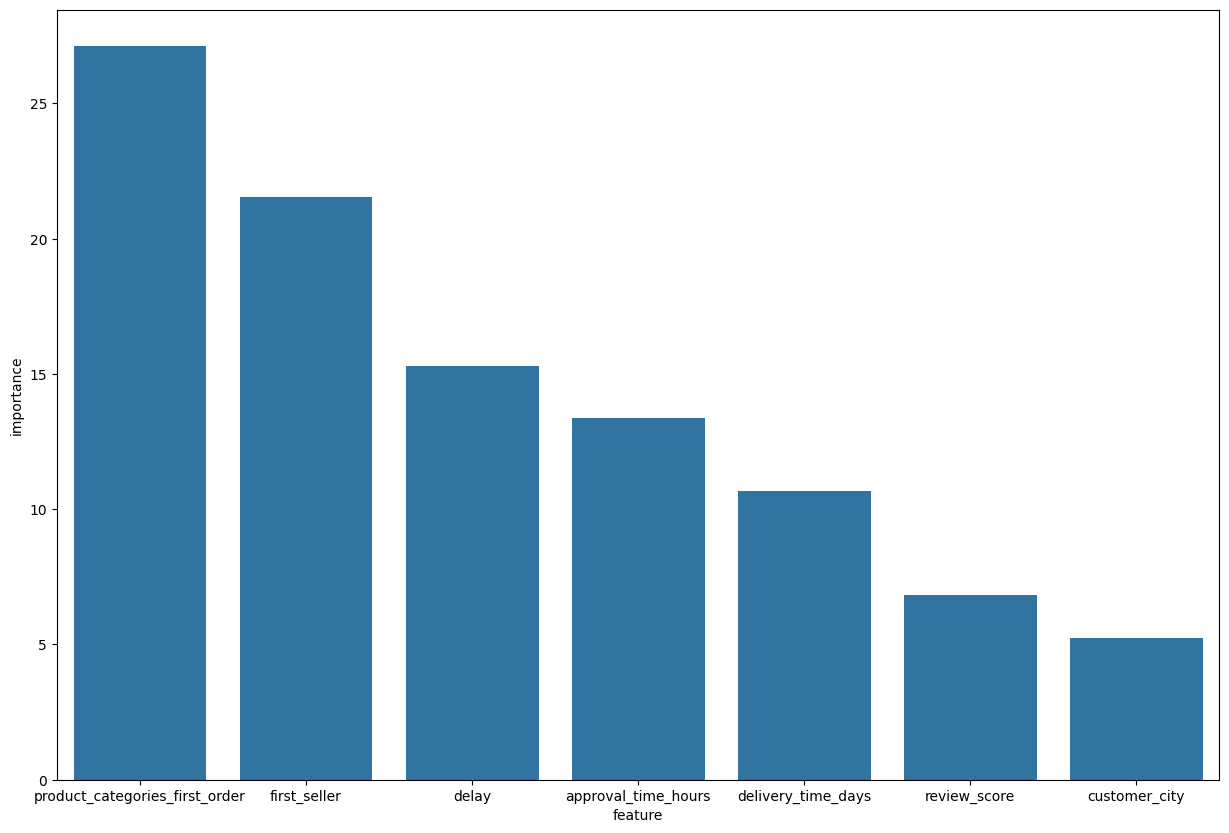

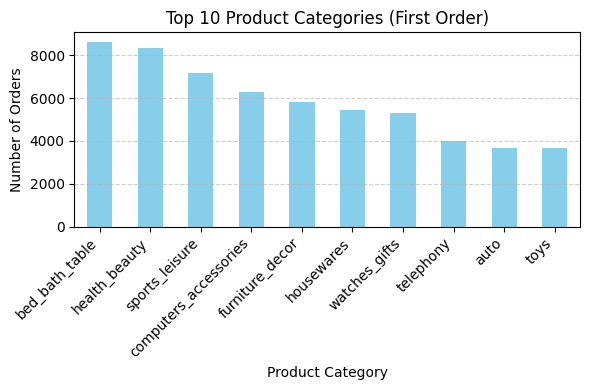

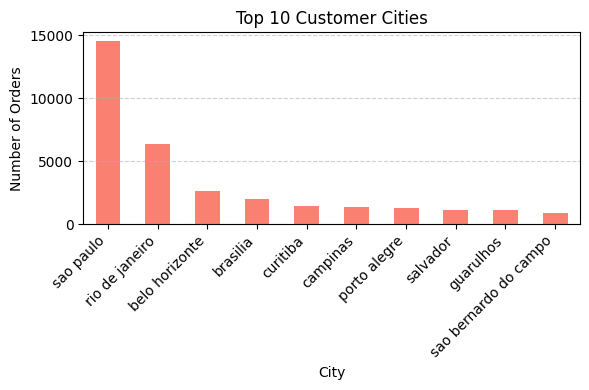

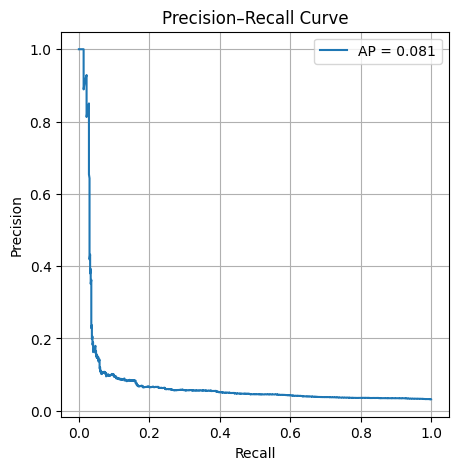

In [28]:
# Feature improtance
plt.figure(figsize=(15, 10))
sns.barplot(data=feat_imp, x='feature', y='importance')
plt.show()

import matplotlib.pyplot as plt

# Product categories (top 10)
top_categories = (
    df_fo_extended['product_categories_first_order']
    .value_counts()
    .head(10)
)

plt.figure(figsize=(6, 4))
top_categories.plot(kind='bar', color='skyblue')
plt.title('Top 10 Product Categories (First Order)')
plt.xlabel('Product Category')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


# Customer cities (top 10)
top_cities = (
    df_fo_extended['customer_city']
    .value_counts()
    .head(10)
)

plt.figure(figsize=(6, 4))
top_cities.plot(kind='bar', color='salmon')
plt.title('Top 10 Customer Cities')
plt.xlabel('City')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


# Precision-recall curve
plt.figure(figsize=(5, 5))
plt.plot(recall, precision, label=f'AP = {ap:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve')
plt.legend()
plt.grid(True)
plt.show()